# Exploratory Data Analysis Source Data

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis-Source-Data" data-toc-modified-id="Exploratory-Data-Analysis-Source-Data-1">Exploratory Data Analysis Source Data</a></span><ul class="toc-item"><li><span><a href="#US-Energy-Information-Administration-(EIA)-Drilling-Productivity-Report" data-toc-modified-id="US-Energy-Information-Administration-(EIA)-Drilling-Productivity-Report-1.1">US Energy Information Administration (EIA) Drilling Productivity Report</a></span></li><li><span><a href="#Nightfire-data" data-toc-modified-id="Nightfire-data-1.2">Nightfire data</a></span></li><li><span><a href="#US-Census-Counties" data-toc-modified-id="US-Census-Counties-1.3">US Census Counties</a></span></li></ul></li></ul></div>

In [516]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [517]:
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib.ticker as mtick
from matplotlib import dates # as mdates
import matplotlib
from matplotlib.dates import DateFormatter

In [518]:
from capstone.etl.eia_retrieval import eia_retrieval
from capstone.etl.eia_parse import eia_parse_county, eia_parse_data
from capstone.etl.census_retrieval import census_retrieval
from capstone.etl.generate_basins import generate_us_basins
from tools.tools import get_current_time, read_json

In [519]:
plt.style.use('ggplot')

In [520]:
config = read_json('../config.json')

current_date = get_current_time('yyyymmdd')

wd = f"{config['workspace_directory']}/data"

## US Energy Information Administration (EIA) Drilling Productivity Report


In [521]:
eia_xls = eia_retrieval(f"{wd}/input/eia")
eia_cnty = eia_parse_county(eia_xls)
eia_data = eia_parse_data(eia_xls)  # parse the target variable(s) data

 parse eia data
    for Anadarko Region
    for Appalachia Region
    for Bakken Region
    for Eagle Ford Region
    for Haynesville Region
    for Niobrara Region
    for Permian Region


In [522]:
eia_data.head(3)

,month,natgas_mcf_d_legacy_production_change,natgas_mcf_d_production_per_rig,natgas_mcf_d_total_production,oil_bbl_d_legacy_production_change,oil_bbl_d_production_per_rig,oil_bbl_d_total_production,region,rig_count
0,2007-01-01,-112112.15,840.713208,4031234.67,-370.40457,19.309806,126398.038,Anadarko Region,176.0
1,2007-02-01,-115386.99,847.042307,4053324.71,-723.02653,20.184060,134177.221,Anadarko Region,180.0
2,2007-03-01,-118312.94,851.808491,4165395.70,-1036.83450,20.970401,137515.513,Anadarko Region,166.0


In [523]:
eia_data.dtypes

month                                    datetime64[ns]
natgas_mcf_d_legacy_production_change           float64
natgas_mcf_d_production_per_rig                 float64
natgas_mcf_d_total_production                   float64
oil_bbl_d_legacy_production_change              float64
oil_bbl_d_production_per_rig                    float64
oil_bbl_d_total_production                      float64
region                                           object
rig_count                                       float64
dtype: object

In [524]:
eia_data.describe()

,natgas_mcf_d_legacy_production_change,natgas_mcf_d_production_per_rig,natgas_mcf_d_total_production,oil_bbl_d_legacy_production_change,oil_bbl_d_production_per_rig,oil_bbl_d_total_production,rig_count
count,1113.000000,1113.000000,1.113000e+03,1113.000000,1113.000000,1.113000e+03,1099.000000
mean,-212149.221062,3015.019143,6.228038e+06,-34171.863542,333.005350,6.011631e+05,140.606915
std,190971.732878,3750.247774,5.757697e+06,47924.001884,416.978172,7.742754e+05,115.153229
min,-997642.260000,77.526847,1.861918e+05,-288983.150000,2.988818,2.400000e+04,16.000000
25%,-292438.000000,954.016977,3.645695e+06,-48592.199000,33.047552,6.500000e+04,56.000000
50%,-152354.960000,1472.449060,4.771623e+06,-14363.063000,131.034944,2.781470e+05,99.000000
75%,-95728.486000,4022.562710,6.790772e+06,-2011.937500,459.616311,9.310919e+05,189.500000
max,-1787.853800,18828.672900,3.384569e+07,-280.865740,1904.260130,4.854688e+06,565.000000


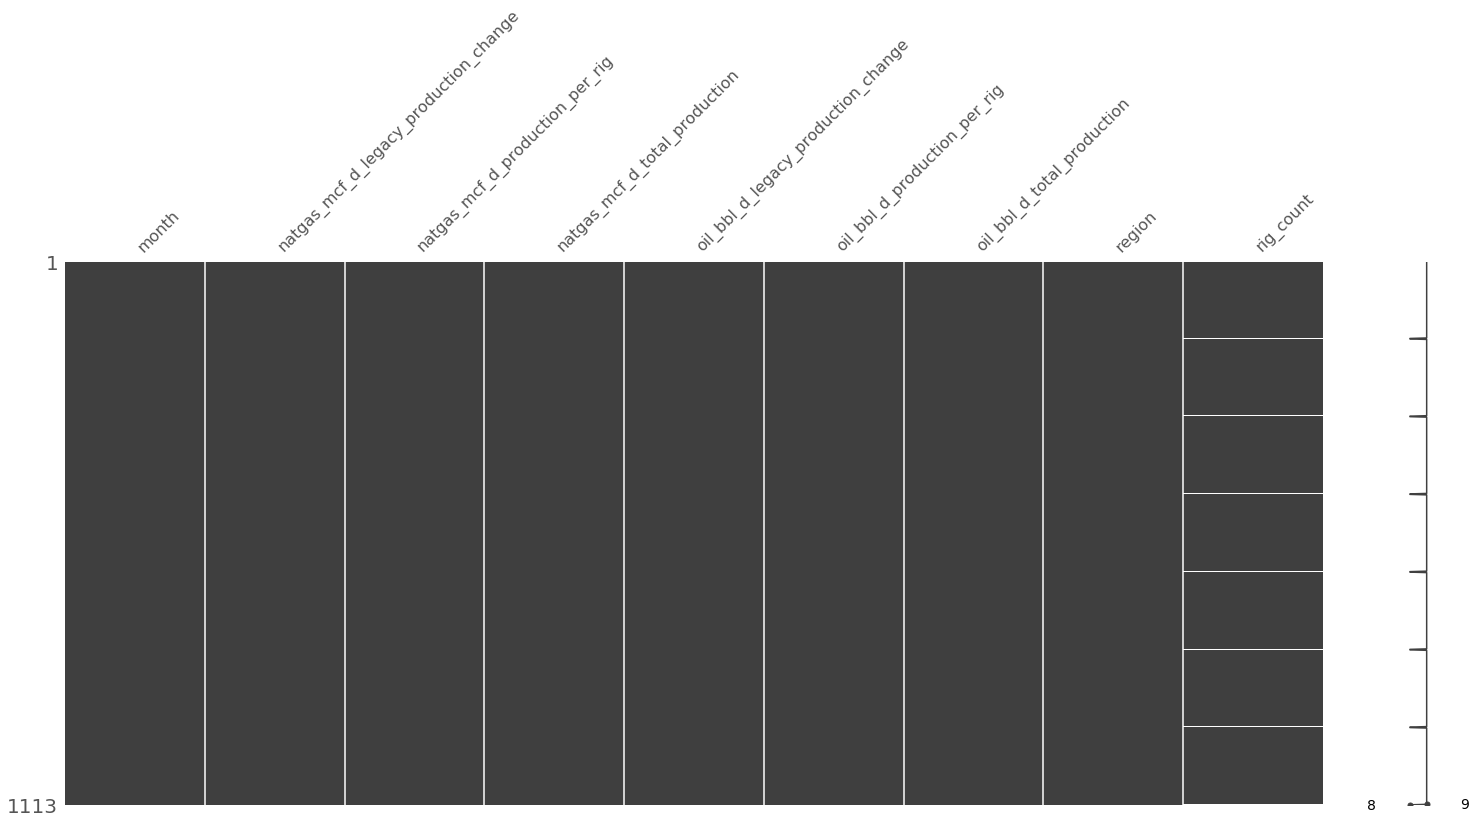

In [525]:
msno.matrix(eia_data);  # check for missing data

In [526]:
# eia_data['yearmonth'] = pd.to_datetime(eia_data['month'].map(lambda x: x.strftime('%Y-%m')))
eia_data

,month,natgas_mcf_d_legacy_production_change,natgas_mcf_d_production_per_rig,natgas_mcf_d_total_production,oil_bbl_d_legacy_production_change,oil_bbl_d_production_per_rig,oil_bbl_d_total_production,region,rig_count
0,2007-01-01,-112112.15,840.713208,4031234.67,-370.40457,19.309806,126398.038,Anadarko Region,176.0
1,2007-02-01,-115386.99,847.042307,4053324.71,-723.02653,20.184060,134177.221,Anadarko Region,180.0
2,2007-03-01,-118312.94,851.808491,4165395.70,-1036.83450,20.970401,137515.513,Anadarko Region,166.0
3,2007-04-01,-121511.37,855.978981,4121693.16,-1379.90980,21.841327,141655.169,Anadarko Region,157.0
4,2007-05-01,-124585.07,859.249200,4201473.29,-1708.89630,22.694143,144415.586,Anadarko Region,170.0
...,...,...,...,...,...,...,...,...,...
154,2019-11-01,-412369.35,1534.824940,16137224.30,-273671.95000,808.588478,4663931.530,Permian Region,408.0
155,2019-12-01,-417586.55,1556.411650,16370217.90,-277375.08000,809.062282,4724744.480,Permian Region,402.0
156,2020-01-01,-423094.38,1561.411650,16584179.40,-281267.78000,811.062282,4774390.110,Permian Region,402.0
157,2020-02-01,-428717.62,1566.411650,16785159.30,-285225.16000,813.062282,4816015.980,Permian Region,NaN


In [533]:
eia_data = eia_data.set_index(['month'])
eia_data.dtypes

natgas_mcf_d_legacy_production_change    float64
natgas_mcf_d_production_per_rig          float64
natgas_mcf_d_total_production            float64
oil_bbl_d_legacy_production_change       float64
oil_bbl_d_production_per_rig             float64
oil_bbl_d_total_production               float64
region                                    object
rig_count                                float64
dtype: object

In [534]:
eia_data

,natgas_mcf_d_legacy_production_change,natgas_mcf_d_production_per_rig,natgas_mcf_d_total_production,oil_bbl_d_legacy_production_change,oil_bbl_d_production_per_rig,oil_bbl_d_total_production,region,rig_count
month,,,,,,,,
2007-01-01,-112112.15,840.713208,4031234.67,-370.40457,19.309806,126398.038,Anadarko Region,176.0
2007-02-01,-115386.99,847.042307,4053324.71,-723.02653,20.184060,134177.221,Anadarko Region,180.0
2007-03-01,-118312.94,851.808491,4165395.70,-1036.83450,20.970401,137515.513,Anadarko Region,166.0
2007-04-01,-121511.37,855.978981,4121693.16,-1379.90980,21.841327,141655.169,Anadarko Region,157.0
2007-05-01,-124585.07,859.249200,4201473.29,-1708.89630,22.694143,144415.586,Anadarko Region,170.0
...,...,...,...,...,...,...,...,...
2019-11-01,-412369.35,1534.824940,16137224.30,-273671.95000,808.588478,4663931.530,Permian Region,408.0
2019-12-01,-417586.55,1556.411650,16370217.90,-277375.08000,809.062282,4724744.480,Permian Region,402.0
2020-01-01,-423094.38,1561.411650,16584179.40,-281267.78000,811.062282,4774390.110,Permian Region,402.0


In [535]:
# ticklabels = [item.strftime('%d-%m-%y') for item in df.index]
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
# ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

# plt.xticks(rotation='90')
# ax.xaxis.grid(True, which='major')

In [536]:
z = eia_data.pivot(columns="region", values=var)
z.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 2007-01-01 to 2020-03-01
Data columns (total 7 columns):
Anadarko Region       159 non-null float64
Appalachia Region     159 non-null float64
Bakken Region         159 non-null float64
Eagle Ford Region     159 non-null float64
Haynesville Region    159 non-null float64
Niobrara Region       159 non-null float64
Permian Region        159 non-null float64
dtypes: float64(7)
memory usage: 9.9 KB


In [559]:
def eia_variable_plot(var, legend_loc=2):
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))

    eia_data.pivot(columns="region", values=var).plot(  
        title=var.replace('_', ' ').upper(),
        ax=ax,
    )

    fmt= '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    ax.yaxis.set_minor_formatter(tick) 

    ax.set_ylabel(var.replace('_', ' ').upper())
    ax.set_xlabel("MONTHLY EIA REPORTS")
    
    plt.legend(title='REGIONS', loc=legend_loc, shadow=True, facecolor='white')

    plt.savefig(f'../images/eia_report_{var}.png', dpi=300)
    plt.show();

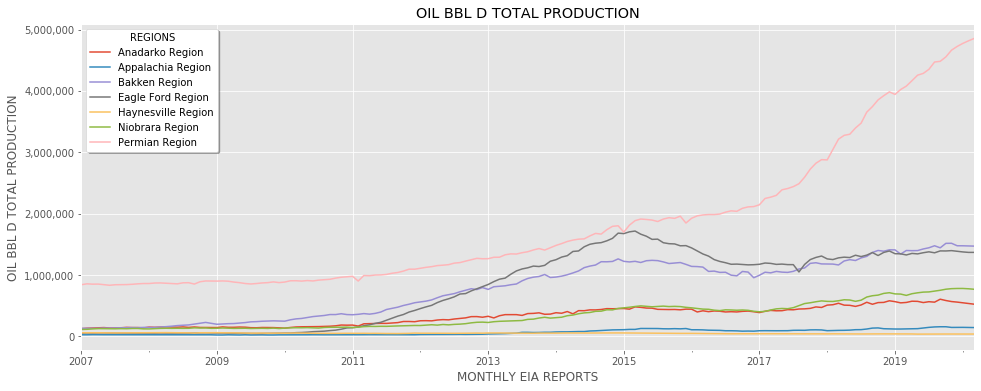

In [560]:
var = 'oil_bbl_d_total_production'
eia_variable_plot(var)

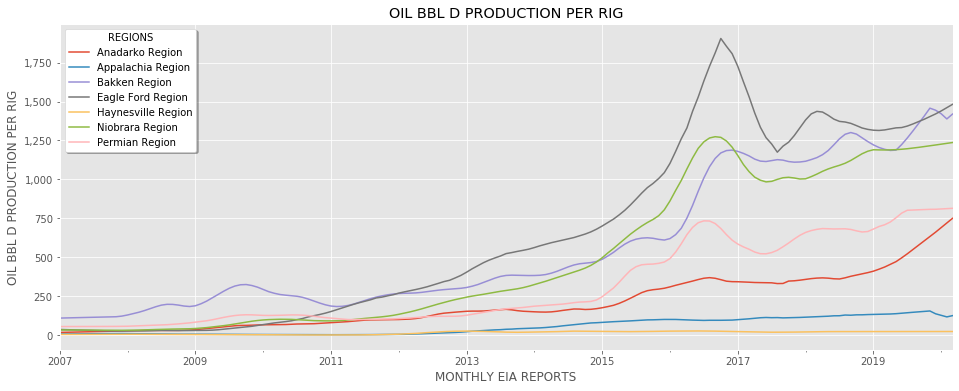

In [539]:
var = 'oil_bbl_d_production_per_rig'
eia_variable_plot(var)

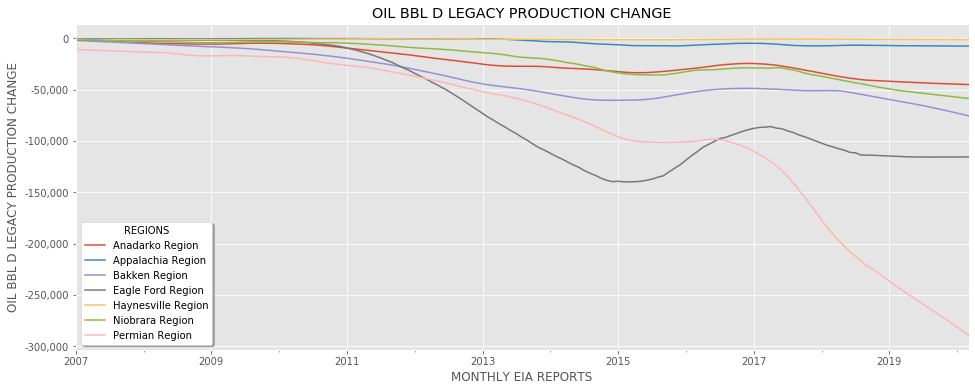

In [540]:
var = 'oil_bbl_d_legacy_production_change'
eia_variable_plot(var, legend_loc=3)

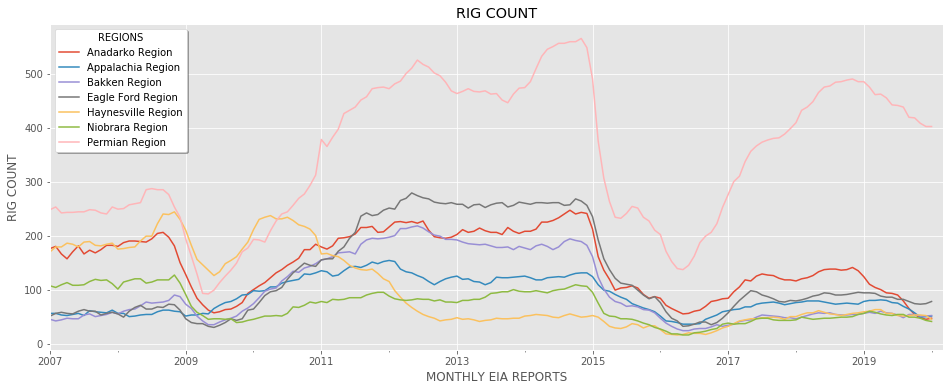

In [541]:
var = 'rig_count'
eia_variable_plot(var)

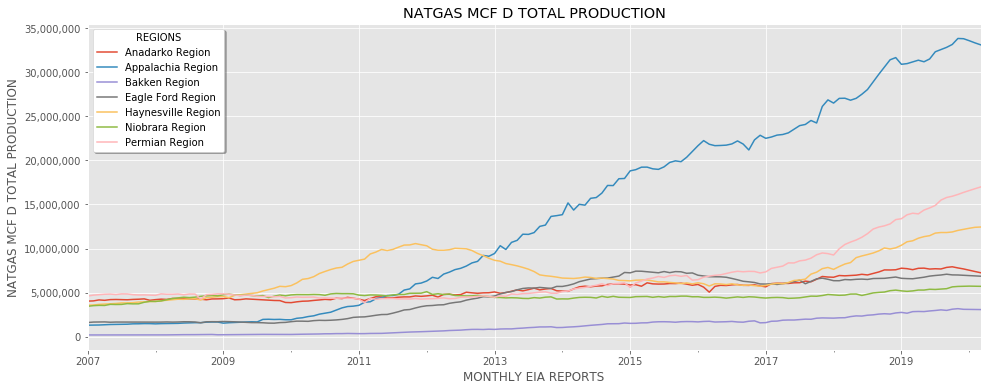

In [542]:
var = 'natgas_mcf_d_total_production'
eia_variable_plot(var)

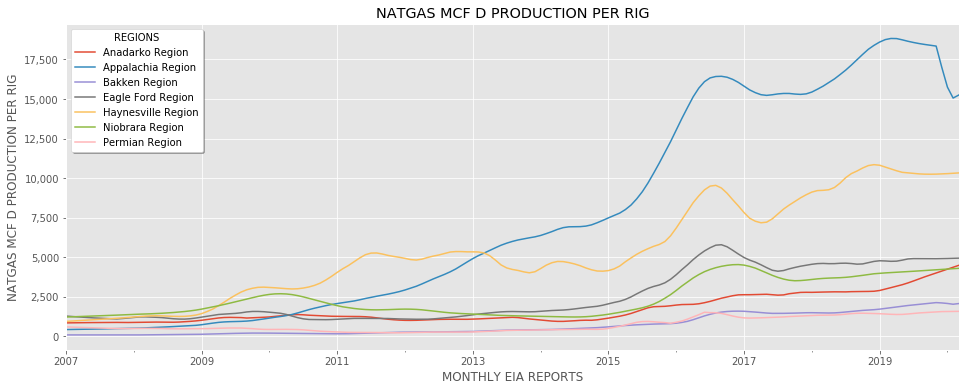

In [543]:
var = 'natgas_mcf_d_production_per_rig'
eia_variable_plot(var)

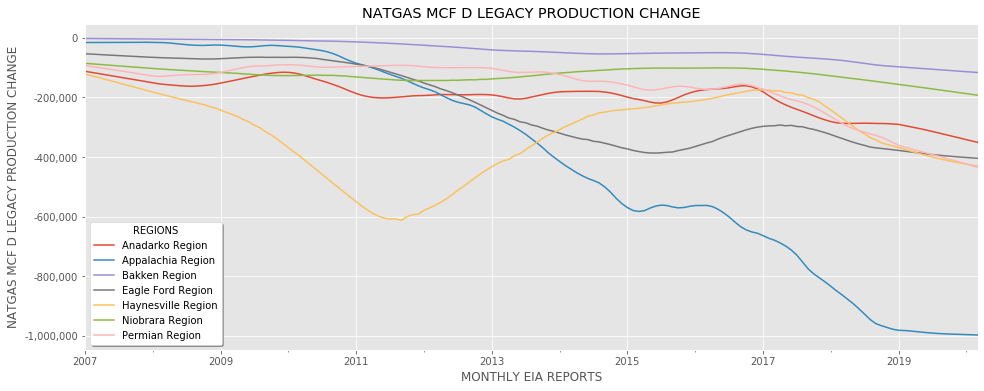

In [544]:
var = 'natgas_mcf_d_legacy_production_change'
eia_variable_plot(var, legend_loc=3)

## Nightfire data


## US Census Counties

In [431]:
census_shp = census_retrieval(f"{wd}/input/census")

census = gpd.read_file(census_shp)

census.columns = [c.lower() for c in census.columns]

census = census[
    (census['statefp'] != '66') & (census['statefp'] != '78') & (census['statefp'] != '69') & (census['statefp'] != '60') & (census['statefp'] != '02') & (census['statefp'] != '15') & (census['statefp'] != '72')
]  # drop alaska and hawaii and island territories for visualization

census = census.to_crs(epsg=5070)  # NAD83 / Conus Albers

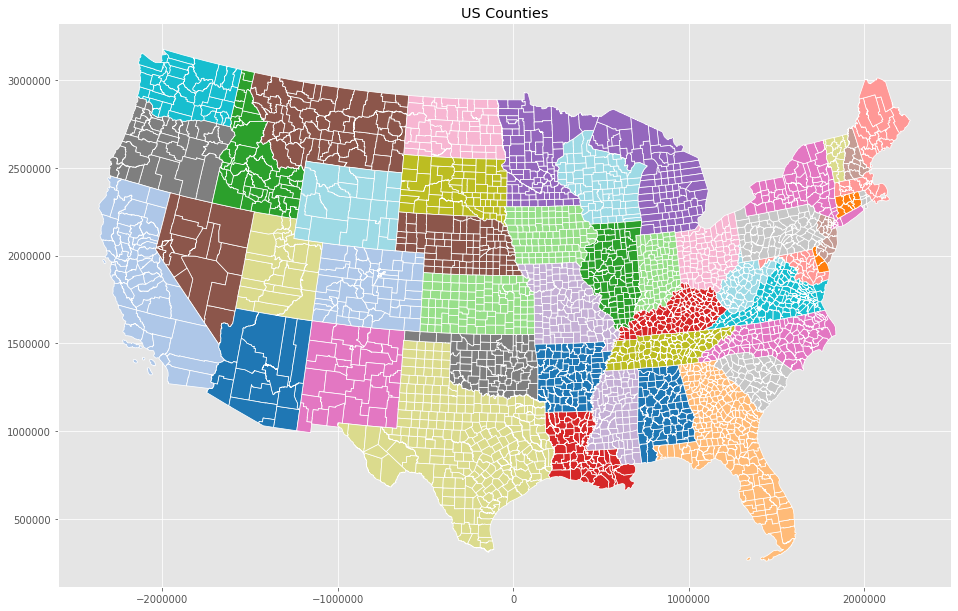

In [432]:
census.plot(figsize=(16, 16), column='statefp', cmap='tab20', edgecolor='white', linewidth=0.75)
plt.title('US Counties');
plt.savefig(f'../images/us.png', dpi=300);

In [433]:
census_gdf = parse_census(census_shp)
basins_list, all_basins = generate_us_basins(
    census_gdf,
    eia_cnty,
    f"{wd}/input/basins",
)

generating us basins
    permian region
    appalachia region
    haynesville region
    eagle ford region
    anadarko region
    niobrara region
    bakken region


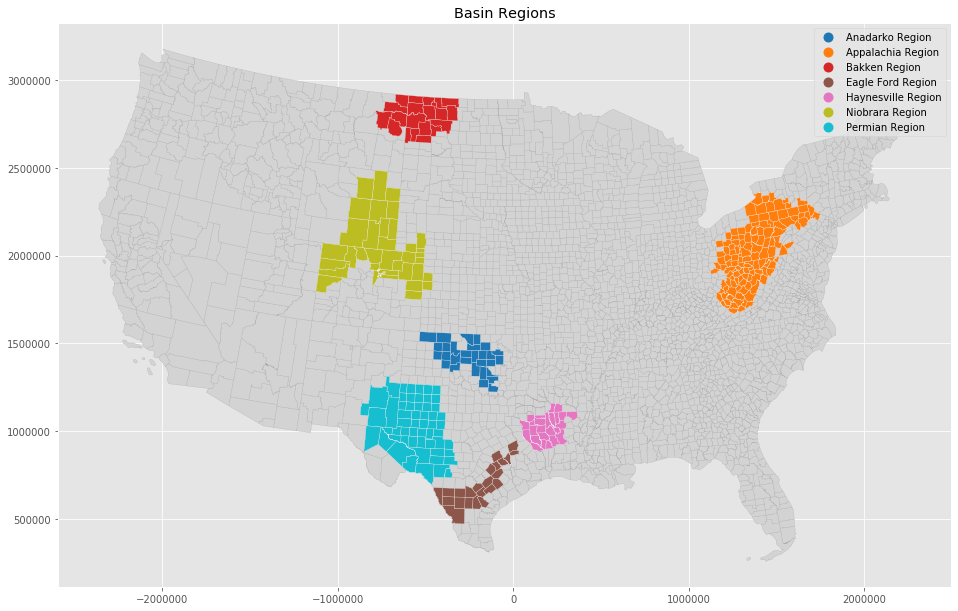

In [438]:
fig, ax = plt.subplots(figsize=(16, 16))

all_basins = all_basins.to_crs(epsg=5070)  # NAD83 / Conus Albers

census.plot(ax=ax, color='lightgray', edgecolor='darkgray', linewidth=0.25, alpha=0.99)
all_basins.plot(ax=ax, column='region', cmap='tab10', edgecolor='white', linewidth=0.25, legend=True)
# ax.legend(loc=4)
plt.title('Basin Regions');